# Song Lyric Classification By Artist
#### Udacity Machine Learning Nanodegree Capstone Project
#### Greg Mogavero

## Project Description
---
Machine learning is commonly used to perform [natural language processing](https://en.wikipedia.org/wiki/Natural_language_processing) (NLP), a “field of computer science, artificial intelligence and computational linguistics concerned with the interactions between computers and human (natural) languages, and, in particular, concerned with programming computers to fruitfully process large natural language corpora.” One particular use case for NLP is analyzing song lyrics to classify them by artist. A successful machine learning algorithm would not only have to take into account the songwriter’s lexicon, but also pick up on the unique subtleties of the artist’s style in order to differentiate artists who write about similar topics.

Efforts have already been made by the machine learning community to classify songs based on their lyrics by genre and artist. [Sadovsky and Chen](https://nlp.stanford.edu/courses/cs224n/2006/fp/sadovsky-x1n9-1-224n_final_report.pdf) used Maxent and SVM classifiers to accomplish this task fairly successfully. Using no acoustic information whatsoever, they were able to achieve 70-80% artist classification accuracy. Because they used Bag of Words for feature selection, they remark that they might have been able to achieve higher accuracy if they did some sort of semantic analysis.
For this project, I will be using a [dataset](https://www.kaggle.com/mousehead/songlyrics) comprised of 57,650 song lyrics scraped from LyricsFreak by Sergey Kuznetsov.

Given song lyrics (text only) as input and the corresponding artists as labels, I will attempt to build a supervised learner that can classify new songs by artist. Input will be truncated or padded during preprocessing so that each sample is a fixed size.

I will attempt to solve the problem of classifying song lyrics by artist by training a Long Short Term Memory (LSTM) Neural Network. These models, when trained on text data, can “remember” information they have seen in the past. I hypothesize that the ability to learn this contextual information will help the learner distinguish songs by different artists who have similar lexicons, but different styles.

In order to get meaningful results, I will choose the 10 artists from the dataset with the largest repertoire of songs. After preprocessing the input text data using Word2Vec, I will train and test a basic LSTM network, analyze its performance, and then try to improve results through hyperparameter tuning and architecture modification. Final results will be compared against a benchmark model based on the models Sadovsky and Chen used in their experiment.

## Data Exploration
---
The first thing we'll do is import the dataset into a Pandas DataFrame.

In [12]:
import pandas as pd
import numpy as np

raw_data = pd.read_csv("./songdata.csv")
raw_data.head()

,artist,song,link,text
0,ABBA,Ahe's My Kind Of Girl,/a/abba/ahes+my+kind+of+girl_20598417.html,"Look at her face, it's a wonderful face \nAnd..."
1,ABBA,"Andante, Andante",/a/abba/andante+andante_20002708.html,"Take it easy with me, please \nTouch me gentl..."
2,ABBA,As Good As New,/a/abba/as+good+as+new_20003033.html,I'll never know why I had to go \nWhy I had t...
3,ABBA,Bang,/a/abba/bang_20598415.html,Making somebody happy is a question of give an...
4,ABBA,Bang-A-Boomerang,/a/abba/bang+a+boomerang_20002668.html,Making somebody happy is a question of give an...


Now let's drop the columns we don't need. Let's also count the number of songs by each artist, print a description of these statistics, and print the top 10 artists with the most songs.

In [13]:
data = raw_data.drop(["song", "link"], axis=1)
num_songs_per_artist = data.groupby(["artist"], as_index=False).count().rename(columns={"text": "song count"})

num_songs_per_artist.describe()

,song count
count,643.000000
mean,89.657854
std,54.689192
min,1.000000
25%,41.000000
50%,86.000000
75%,141.000000
max,191.000000


In [14]:
num_songs_per_artist.sort_values("song count", inplace=True, ascending=False)
num_songs_per_artist.reset_index(drop=True, inplace=True)
num_songs_per_artist[:10]

,artist,song count
0,Donna Summer,191
1,Gordon Lightfoot,189
2,Bob Dylan,188
3,George Strait,188
4,Cher,187
5,Alabama,187
6,Reba Mcentire,187
7,Loretta Lynn,187
8,Dean Martin,186
9,Chaka Khan,186


We can see that the number of songs per artist ranges from 1 to 191, with a mean of 89.658 and a standard deviation of 54.689. If we were to use the entire dataset, we would see a big class imbalance, and the supervised learner would struggle to learn anything meaningful about the artists with a relatively small number of songs. But if we just use the 10 artists with the most songs, we get a dataset with fairly balanced classes. This also ensures we will get a meaningful accuracy score when evaluating our model's performance. Let's reduce our dataset down to these 10 artists now.

In [15]:
data = data[data["artist"].map(lambda x: x in num_songs_per_artist["artist"][:10].values)]
data.reset_index(drop=True, inplace=True)

# describe the stats of the new dataset
data.groupby(["artist"], as_index=False).count().rename(columns={"text": "song count"}).describe()

,song count
count,10.000000
mean,187.600000
std,1.505545
min,186.000000
25%,187.000000
50%,187.000000
75%,188.000000
max,191.000000


We can see that the new dataset is much more balanced.

## Benchmark Model
---
For my benchmark, I will use an SVM classifier (like in Sadovsky and Chen's experiment) on the preprocessed song lyrics. However, my model is much simpler and only uses sklearn's CountVectorizer with mostly default parameters to create the bag of words, whereas Sadovsky and Chen first found word importances through a maxent classifier and constructed the bag of words using only the most important features. Given that this is just a benchmark model, I elected to go with a quicker, simpler solution.

Benchmark accuracy score: 0.287
Confusion matrix, without normalization


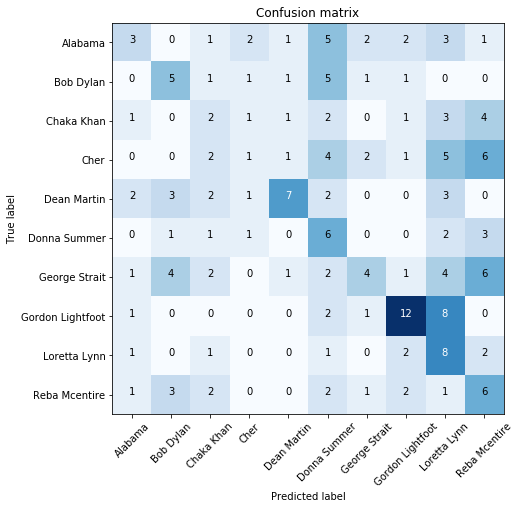

In [23]:
%matplotlib inline

import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from visualization import plot_confusion_matrix

y = data["artist"]
X = CountVectorizer(stop_words="english", max_features=250).fit_transform(data["text"])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state=42)

clf = SVC(random_state=42)
clf.fit(X_train, y_train)
pred = clf.predict(X_test)

print("Benchmark accuracy score: {:.3f}".format(accuracy_score(y_test, pred)))
class_names = data["artist"].unique()
plt.figure(figsize=(7, 7))
plot_confusion_matrix(confusion_matrix(y_test, pred, labels=class_names), class_names)

With 10 labels and only considering the 250 most frequent words (stopwords removed), the benchmark model achieved an accuracy score of 28.7%. This is a little better than random guessing, and it means that supervised learners can learn to distinguish artists with some success based on word frequency alone. This makes sense since artists generally sing about a wide variety of topics, and different artists might sing about the same topic.

Once again it's important to note that we can't use Sadovsky and Chen's results as a benchmark (they achieved around 70% accuracy for artist classification) because our dataset is different and I'm attempting to classify songs among 10 different artists (they used at most 5).

## Preprocessing
---
For the first step of preprocessing the data, we need to convert the words in our text input into numerical representations. I chose to represent each word by its frequency rank, and the rank ascends from most frequent word to the least frequent word. Rank 0 is special in that it represents words that we won't consider because they appear too infrequently. The maximum number of words to consider can be passed as a parameter to the words_to_index() function.

In [17]:
import collections
import pickle
from time import time
from keras.preprocessing.text import text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences

def words_to_index(data, column, max_words=None, length=None, fp=None):
    """Translates words into integers representing their frequency rank.
    
    Parameters:
    data -- A Pandas DataFrame.
    column -- The label of the column to process.
    max_words -- The maximum number of most common words to consider. A value of None means all words will be considered.
    length -- Make each entry a fixed length through zero-padding or truncation. None does not fix the length.
    fp -- The filepath to save the Pickle dump of the processed dataset.
    
    Returns:
    new_data -- A list of lists containing the processed data.
    index -- A dict mapping words to their index.
    reverse_index -- A dict mapping indices to words.
    """
    # First tokenize the entire corpus of words into a flattened list
    words = []
    song_indices = [0]
    last_index = 0
    print("Tokenizing...")
    start = time()
    for sample in data[column].values:
        tokens = text_to_word_sequence(sample)
        song_indices.append(len(tokens) + last_index)
        words.extend(tokens)
        last_index += len(tokens)
    print("Finished tokenizing after {:.3f}s".format(time() - start))
    
    # Count each word, then build an index out of the most common words
    count = [("NULL", -1)]
    count.extend(collections.Counter(words).most_common(max_words))
    index = {}
    for word, _ in count:
        index[word] = len(index)
    reverse_index = dict(zip(index.values(), index.keys()))
        
    # Convert the words in each entry into their numerical representations using the index
    new_data = []
    print("Converting words to indices...")
    start = time()
    for i in range(data.shape[0]):
        new_sample = []
        sample = words[song_indices[i]:song_indices[i+1]]
        for word in sample:
            if word in index:
                new_sample.append(index[word])
            else:
                new_sample.append(0)
        new_data.append(new_sample)
    print("Finished after {:.3f}s".format(time() - start))
    
    # Pad or truncate each entry
    if length != None:
        new_data = pad_sequences(new_data, length, padding="post", truncating="post")
    
    # If a filepath is provided, dump the processed dataset to disk
    if fp != None:
        print("Dumping data...")
        with open(fp, "wb") as f:
            pickle.dump((new_data, index, reverse_index), f)
            
    return new_data, index, reverse_index

X, index, reverse_index = words_to_index(data, "text", max_words=5000, length=500, fp="./word_indices.pkl")

print("\nExample song before preprocessing")
print("-" * 80)
print(data.at[0, "text"])

print("\nSong after preprocessing")
print("-" * 80)
print(X[0])

Tokenizing...
Finished tokenizing after 0.207s
Converting words to indices...
Finished after 0.336s
Dumping data...

Example song before preprocessing
--------------------------------------------------------------------------------
Calling, calling all angels, oh I'm calling, calling all angels  
  
The night was still, the moon was bright when he saw a distant light  
So he started walkin' till he found a church outside of town  
And he stumbled in and closed the door, said why I'm here, I'm not sure  
It's my baby that I'm lookin' for, can't she see I'm down on my knees  
  
I've been calling, calling all angels, bring my baby back  
Oh you must know where she's at, tell me what to do, I know she's one of you  
I'm down on my knees, tell her please, that I love her so  
  
Tell me preacher, man to man, will you do all that you can  
I've done wrong, this I know, and I really hurt her so  
It's a lonely world I'm livin' in, an ocean of tears I been cryin'  
In this greatest hour of ne